# Walking Droplet 

We will assume PDE is in the form of system of ODEs
$$\mathbf{f}_1 = P_1(s)$$
$$\mathbf{f}_2 = P_2(s)$$
$$\mathbf{f}_3 = P_3(s)$$
$$\mathbf{f}_4 = P_4(s)$$

where $\mathbf{f}_1:=x_1'$, $\mathbf{f}_2 = x_2'$, $\mathbf{f}_3 = x_1''$, $\mathbf{f}_4 = x_2''$ and $s = (x_1, x_2, x_1', x_2')$?

Have approximately 4 minutes worth of data with times stamps every $dt = \frac{1}{30}$ seconds.

## Upload `kernel_pdes_utils.py` file and `control.csv` file.

In [1]:
# Get kernel_pde_utils.py file
! gdown --id 1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ

# Get control.csv droplet data
! gdown --id 1wzlXGMIirxRgAxkDMatILrOZbKPkwbuX

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ
To: /content/kernel_pde_utils.py
100% 4.81k/4.81k [00:00<00:00, 20.7MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wzlXGMIirxRgAxkDMatILrOZbKPkwbuX
To: /content/control.csv
100% 617k/617k [00:00<00:00, 33.3MB/s]


In [27]:
import pandas as pd
from kernel_pde_utils import *
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

data_path = "/content/control.csv"
control_df = pd.read_csv(data_path)

In [3]:
Xs = control_df[["x1","y1"]].to_numpy()
ts = control_df.time.to_numpy()

dt_inv = 30

In [4]:
times = control_df.time.to_numpy()

In [5]:
time_diff=times[1:]-times[0:-1]

In [6]:
index = time_diff >0.04
time_diff[index]

array([], dtype=float64)

## Apply the pipeline

Let's just try for the first 5 seconds of [video](https://drive.google.com/file/d/1I8EnRhZLNRLKuS-yIPAS5WyrP-uJh6HQ/view?usp=sharing).

In [7]:
def kernel_pipeline(Xs, ts, train_time, params, normalize=True):
  dt_inv = 30
  X = Xs[:train_time*dt_inv,:]
  t = ts[:train_time*dt_inv]

  if normalize==True:
    X=X-np.mean(X,axis=0,keepdims=True)
    X=X/np.std(X,axis=0,keepdims=True)

  # Smooth data
  kernel_metric1 = params["smoothing_X1"]["kernel_metric"]
  kernel_metric2 = params["smoothing_X2"]["kernel_metric"]

  kernel_params1 = params["smoothing_X1"]["kernel_params"]
  kernel_params2 = params["smoothing_X2"]["kernel_params"]

  _lambda1 = params["smoothing_X1"]["_lambda"]
  _lambda2 = params["smoothing_X2"]["_lambda"]

  X1_smooth_func = kernel_smoothing(t.reshape(-1,1), X[:,0],
                                    kernel_metric = kernel_metric1,
                                    kernel_params = kernel_params1,
                                    _lambda = _lambda1)
  X2_smooth_func = kernel_smoothing(t.reshape(-1,1), X[:,1],
                                    kernel_metric = kernel_metric2,
                                    kernel_params = kernel_params2,
                                    _lambda = _lambda2)
  
  # Evaluate smooth functions
  X1_est = X1_smooth_func(t.reshape(-1,1))
  X2_est = X2_smooth_func(t.reshape(-1,1))

  # Get first and second derivatives
  def centered_diff(f):
    """
    Compute centered differeince derivative approximation of vector f
    """
    f_vec = f
    dx = 1/30
    df = np.zeros(len(f))
    # Internal mesh points
    df[1:-1] = (f_vec[2:] - f_vec[:-2])/(2*dx)
    # End points
    df[0]  = (f_vec[1]  - f_vec[0]) /dx
    df[-1] = (f_vec[-1] - f_vec[-2])/dx
    return df
  
  X1_d_est = centered_diff(X1_est)
  X2_d_est = centered_diff(X2_est)

  X1_dd_est = centered_diff(X1_d_est)
  X2_dd_est = centered_diff(X2_d_est)
  

  # Define forcing and S vectors
  F1 = X1_d_est
  F2 = X2_d_est
  F3 = X1_dd_est
  F4 = X2_dd_est

  S = np.vstack([X1_est, X2_est, X1_d_est, X2_d_est]).T

  # Apply kernel Regression
  _lambda1 = params["regression_X1"]["_lambda"]
  _lambda2 = params["regression_X2"]["_lambda"]
  _lambda3 = params["regression_X3"]["_lambda"]
  _lambda4 = params["regression_X4"]["_lambda"]

  kernel_metric1 = params["regression_X1"]["kernel_metric"]
  kernel_metric2 = params["regression_X2"]["kernel_metric"]
  kernel_metric3 = params["regression_X3"]["kernel_metric"]
  kernel_metric4 = params["regression_X4"]["kernel_metric"]

  kernel_params1 = params["regression_X1"]["kernel_params"]
  kernel_params2 = params["regression_X2"]["kernel_params"]
  kernel_params3 = params["regression_X3"]["kernel_params"]
  kernel_params4 = params["regression_X4"]["kernel_params"]
  

  P1 = kernel_regression(S,F1,
                       kernel_metric=kernel_metric1,
                       kernel_params = kernel_params1,
                       _lambda = _lambda1)
  P2 = kernel_regression(S,F2,
                        kernel_metric=kernel_metric2,
                        kernel_params = kernel_params2,
                        _lambda = _lambda2)
  P3 = kernel_regression(S, F3,
                        kernel_metric=kernel_metric3,
                        kernel_params = kernel_params3,
                        _lambda = _lambda3)
  
  P4 = kernel_regression(S, F4,
                        kernel_metric=kernel_metric4,
                        kernel_params = kernel_params4,
                        _lambda = _lambda4)
  
  return P1, P2, P3, P4, t, X, X1_est, X2_est, S

def plotting(sol, t, time_end, P1, P2, X, X1_est, X2_est, S):
  dt_inv=30
  # Create a subplot with two plots
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Left plot
  m=time_end*dt_inv
  # t_solve = t[:m]
  axs[0].plot(t[:m], X[:m, 0], label='true x', c='black')
  axs[0].plot(t[:m], X[:m, 1], label='true y', c='blue')
  # axs[0].plot(t[:m], X1_est[:m], label='smooth x', c='black', linestyle="-.")
  # axs[0].plot(t[:m], X2_est[:m], label='smooth y', c='blue', linestyle="-.")
  axs[0].plot(t_solve, sol.y[0, :m], label='approx x', c='black', linestyle='--')
  axs[0].plot(t_solve, sol.y[1, :m], label='approx y', c='blue', linestyle='--')
  axs[0].set_xlabel('t', fontsize=16)
  axs[0].set_ylabel(r'$x(t)$, $y(t)$',fontsize=16)
  axs[0].set_title('True and Approximate Values', fontsize=20)
  axs[0].legend()

  # Right plot
  axs[1].plot(t[:m], P1(S)[:m], label=r'$\overline{\mathcal{P}}_1$', c='black')
  axs[1].plot(t[:m], P2(S)[:m], label=r'$\overline{\mathcal{P}}_2$', c='blue')
  axs[1].set_xlabel('t',fontsize=16)
  axs[1].set_ylabel(r'$\overset{\bullet}{x}(t)$, $\overset{\bullet}{y}(t)$',fontsize=16)
  axs[1].set_title(r'Learned ODEs',fontsize=20)
  axs[1].legend()

  # Adjust spacing between plots
  fig.tight_layout()

  # Display the plot
  plt.show()

In [8]:
good_params_dict = {
    "smoothing_X1": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma": 1e-1},
        "_lambda": 1e-5
    },
    "smoothing_X2": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma": 1e-1},
        "_lambda": 1e-5
    },
    "diff_X1": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1},
        "_lambda": 1e-5
    },
    "diff_X2": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1},
        "_lambda": 1e-5
    },
    "regression_X1": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    },
    "regression_X2": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    },
    "regression_X3": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    },
    "regression_X4": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    }
}

params_dict = {
    "smoothing_X1": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma": 1e-1},
        "_lambda": 1e-5
    },
    "smoothing_X2": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma": 1e-1},
        "_lambda": 1e-5
    },
    "diff_X1": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1},
        "_lambda": 1e-5
    },
    "diff_X2": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1},
        "_lambda": 1e-5
    },
    "regression_X1": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    },
    "regression_X2": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    },
    "regression_X3": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    },
    "regression_X4": {
        "kernel_metric": "rbf",
        "kernel_params": {"gamma":1e-4},
        "_lambda": 1e-2
    }
}

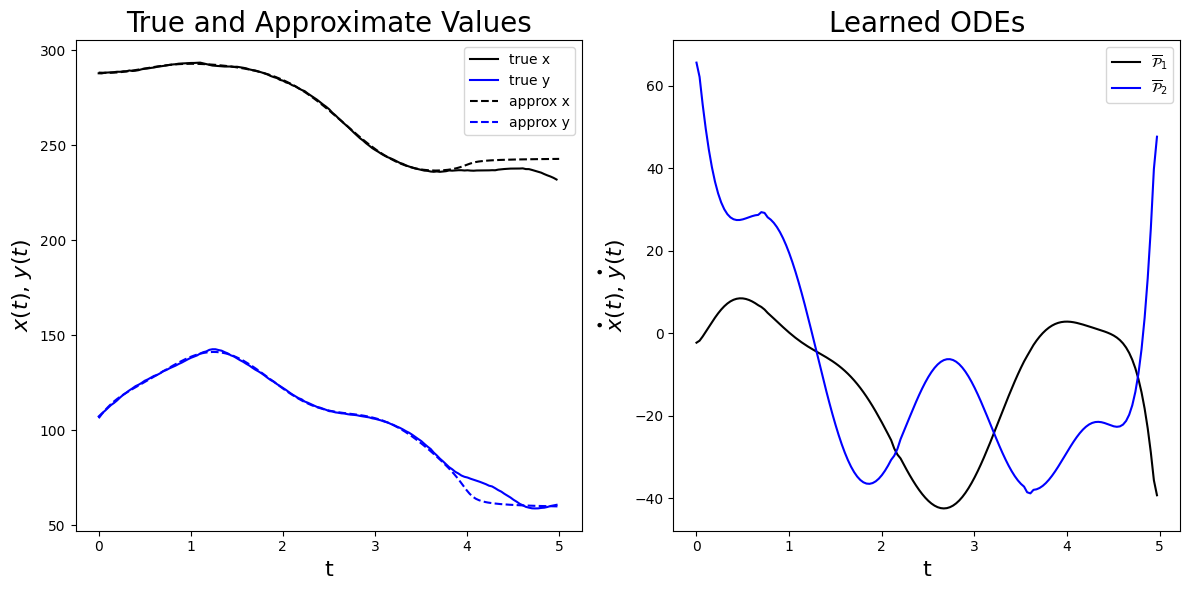

In [9]:
P1, P2, P3, P4, t, X, X1_est, X2_est, S=kernel_pipeline(Xs,
                                          ts,
                                          train_time=5,
                                          params=params_dict, 
                                          normalize=False)

def ode_sys(t,y, P1=P1, P2=P2, P3=P3, P4=P4):
  u1, u2, u3, u4 = y
  input = np.array([[u1,u2, u3,u4]])
  p1 = P1(input)[0]
  p2 = P2(input)[0]
  p3 = P3(input)[0]
  p4 = P4(input)[0]
  return [p1,p2,p3,p4]

y0 = S[0]
# y0 = [X1_est[0], X2_est[0]]
time_end = 5
t_solve = np.linspace(0,time_end,time_end*dt_inv)
sol = solve_ivp(ode_sys,
                t_span=(t_solve[0], t_solve[-1]),
                y0=y0,
                t_eval = t_solve)

plotting(sol,
         t=t,
         time_end=time_end,
         P1=P1,
         P2=P2,
         X=X,
         X1_est=X1_est,
         X2_est=X2_est,
         S=S)

## Create report plot

In [22]:
# Get droplet experiment image
! gdown --id 11SM3nLI1dnzmviTMO4_Fcy0x9KH2hQwU

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11SM3nLI1dnzmviTMO4_Fcy0x9KH2hQwU
To: /content/droplet.png
100% 1.61M/1.61M [00:00<00:00, 35.2MB/s]


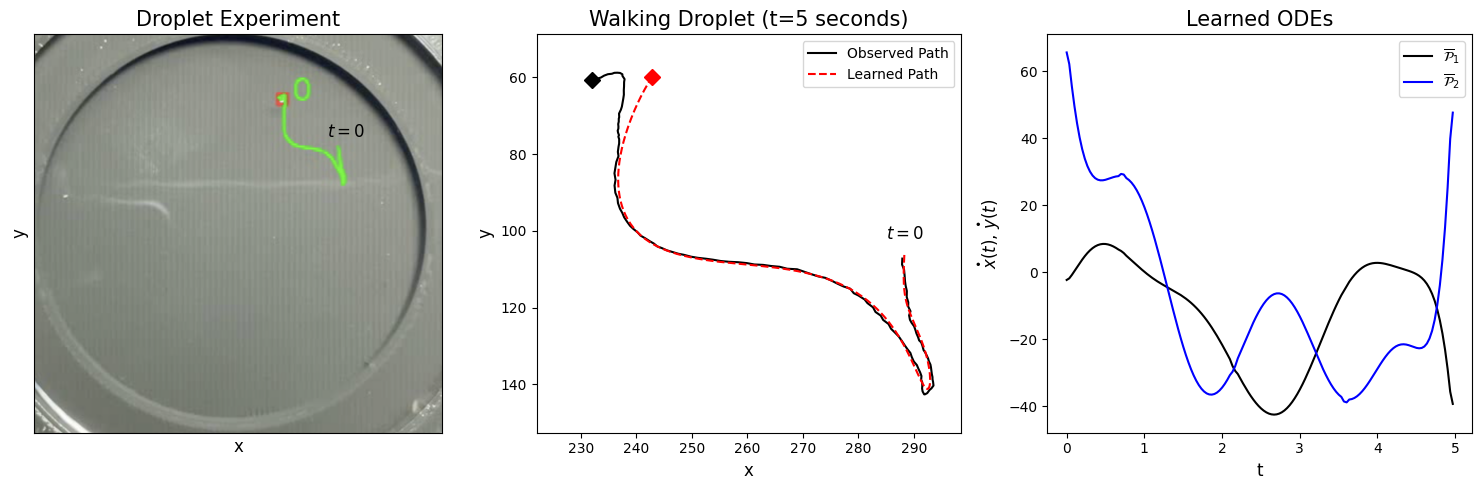

In [88]:
dt_inv = 30
m=time_end*dt_inv

# Load the image
img = mpimg.imread('/content/droplet.png')

# Set the desired figure size (width, height) in inches
figure_size = (15, 5)
label_fontsize = 12
title_fontsize = 15

# Set up the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=figure_size)

# Plot the photo in the first subplot
axs[0].imshow(img, aspect='equal')  # Set aspect to 'equal' to make it square
axs[0].set_title('Droplet Experiment',fontsize=title_fontsize)

axs[0].set_xlabel("x", fontsize=label_fontsize)
axs[0].set_ylabel("y", fontsize=label_fontsize)

axs[0].text(1000,350, r"$t=0$", size=12)

# Modify the x-axis ticks in the first subplot
# axs[0].set_xticks(np.linspace(-1, 1, 100))  # Set the ticks to -1, -0.5, 0, 0.5, 1
axs[0].set_xticks([])
axs[0].set_yticks([])

# Given x and y coordinates
x = X[:, 0]
y = X[:, 1]

# Additional x and y coordinates
x2 = sol.y[0, :]
y2 = sol.y[1, :]

# Set up the figure with a fixed size
axs[1].set_title("Walking Droplet (t=5 seconds)", fontsize=title_fontsize)
axs[1].set_xlim(min(x) - 10, max(x) + 5)
axs[1].set_ylim(max(y) + 10, min(y) - 10)

# Set x-axis and y-axis labels
axs[1].set_xlabel("x", fontsize=label_fontsize)
axs[1].set_ylabel("y", fontsize=label_fontsize)

# Plot the first path
axs[1].plot(x, y, 'k-', label="Observed Path")

# Plot the second path
axs[1].plot(x2, y2, 'r--', label="Learned Path")

# Add diamond marker to the last position of each path
axs[1].plot(x[-1], y[-1], 'kD', markersize=8)
axs[1].plot(x2[-1], y2[-1], 'rD', markersize=8)

# Add t=0 start time
axs[1].text(x[0]-3, y[0]-5, r"$t=0$", size=12)

axs[1].legend(loc='upper right')

# Plot learned odes
 # Right plot
axs[2].plot(t[:m], P1(S)[:m], label=r'$\overline{\mathcal{P}}_1$', c='black')
axs[2].plot(t[:m], P2(S)[:m], label=r'$\overline{\mathcal{P}}_2$', c='blue')
axs[2].set_xlabel('t',fontsize=label_fontsize)
axs[2].set_ylabel(r'$\overset{\bullet}{x}(t)$, $\overset{\bullet}{y}(t)$',
                  fontsize=label_fontsize)
axs[2].set_title(r'Learned ODEs',
                 fontsize=title_fontsize)
axs[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

plt.savefig("droplet_results.pdf")
# Display the plot
plt.show()


## Create gif

In [11]:
! pip install matplotlib pillow
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-12-c529bf918e5c>:41: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  leading1.set_data(x[i], y[i])  # Update the leading point position
<ipython-input-12-c529bf918e5c>:45: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  leading2.set_data(x2[i], y2[i])  # Update the leading point position


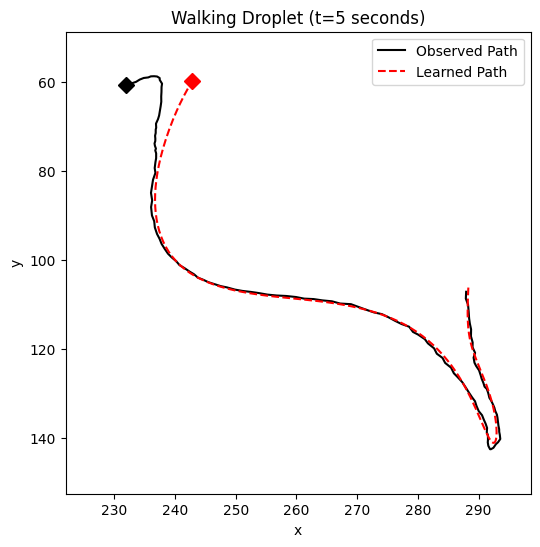

In [12]:
# Given x and y coordinates
x = X[:,0]
y = X[:,1]

# Additional x and y coordinates
x2 = sol.y[0,:]
y2 = sol.y[1,:]

# Set the desired figure size (width, height) in inches
figure_size = (6, 6)

# Set up the figure with a fixed size
fig, ax = plt.subplots(figsize=figure_size)
ax.set_title("Walking Droplet (t=5 seconds)")
ax.set_xlim(min(x)-10, max(x)+5)
ax.set_ylim(max(y)+10, min(y)-10)

# Set x-axis and y-axis labels
ax.set_xlabel("x")
ax.set_ylabel("y")

# Create an empty list to store frames
frames = []

# Plot the initial points
line1, = ax.plot([], [], 'k-', label="Observed Path")
line2, = ax.plot([], [], 'r--', label="Learned Path")

# Set marker style for the leading point
leading_marker = 'D'  # Change this to the desired leading marker style
leading_size = 8  # Change this to adjust the size of the leading marker

# Plot the leading point with the specified marker style
leading1, = ax.plot([], [], 'k', marker=leading_marker, markersize=leading_size)
leading2, = ax.plot([], [], 'r', marker=leading_marker, markersize=leading_size)

# Iterate through each coordinate point
for i in range(len(x)):
    # Update the plot data for the first set of coordinates
    line1.set_data(x[:i+1], y[:i+1])
    leading1.set_data(x[i], y[i])  # Update the leading point position
    
    # Update the plot data for the second set of coordinates
    line2.set_data(x2[:i+1], y2[:i+1])
    leading2.set_data(x2[i], y2[i])  # Update the leading point position

    # Add legend
    ax.legend(loc='upper right')

    # Save the plot as an image
    fig.canvas.draw()
    frame = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    frames.append(frame)


# Save the frames as a GIF
frames[0].save('marked_path.gif', format='GIF', append_images=frames[1:], save_all=True, duration=67, loop=0)


## Other Gifs

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tyOG1nwDlJgryvbWPQ2u7Hw423Uas3kJ
To: /content/cute_droplet.png
100% 19.9k/19.9k [00:00<00:00, 80.1MB/s]


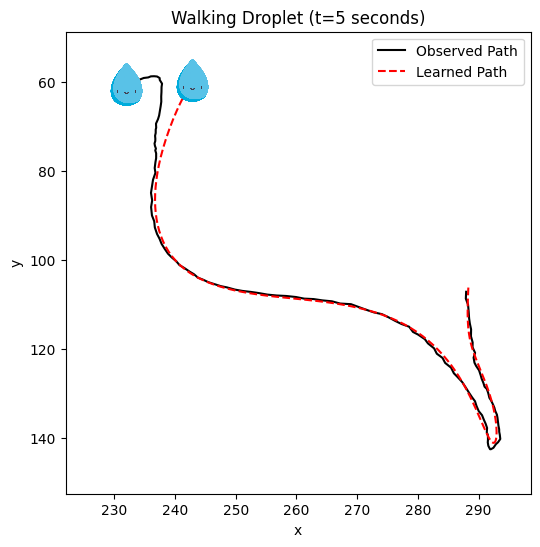

In [13]:
# #Droplet image download
# ! gdown --id 1tyOG1nwDlJgryvbWPQ2u7Hw423Uas3kJ

# # Given x and y coordinates
# x = X[:, 0]
# y = X[:, 1]

# # Additional x and y coordinates
# x2 = sol.y[0, :]
# y2 = sol.y[1, :]

# # Set the desired figure size (width, height) in inches
# figure_size = (6, 6)

# # Set up the figure with a fixed size
# fig, ax = plt.subplots(figsize=figure_size)
# ax.set_title("Walking Droplet (t=5 seconds)")
# ax.set_xlim(min(x) - 10, max(x) + 5)
# ax.set_ylim(max(y) + 10, min(y) - 10)

# # Set x-axis and y-axis labels
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# # Create an empty list to store frames
# frames = []

# # Plot the initial points
# line1, = ax.plot([], [], 'k-', label="Observed Path")
# line2, = ax.plot([], [], 'r--', label="Learned Path")

# # Load the image for the custom marker
# marker_image_path = '/content/cute_droplet.png'  # Replace with your custom marker image path
# marker_image = plt.imread(marker_image_path)

# # Set marker size for the leading point
# # leading_size = 40  # Adjust the size of the leading marker

# # Iterate through each coordinate point
# for i in range(len(x)):
#     # Update the plot data for the first set of coordinates
#     line1.set_data(x[:i + 1], y[:i + 1])

#     # Update the plot data for the second set of coordinates
#     line2.set_data(x2[:i + 1], y2[:i + 1])

#     # Clear the previous marker annotation
#     if i > 0:
#         marker_annotation1.remove()
#         marker_annotation2.remove()

#     # Create an annotation box for the leading point using the marker image
#     marker_annotation1 = AnnotationBbox(OffsetImage(marker_image, zoom=0.06), (x[i], y[i]), frameon=False)
#     marker_annotation2 = AnnotationBbox(OffsetImage(marker_image, zoom=0.06), (x2[i], y2[i]), frameon=False)

#     # Add the annotation box to the plot
#     ax.add_artist(marker_annotation1)
#     ax.add_artist(marker_annotation2)

#     # Add legend
#     ax.legend(loc='upper right')

#     # Save the plot as an image
#     fig.canvas.draw()
#     frame = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
#     frames.append(frame)

# # Save the frames as a GIF
# frames[0].save('cool_path.gif', format='GIF', append_images=frames[1:], save_all=True, duration=67, loop=0)


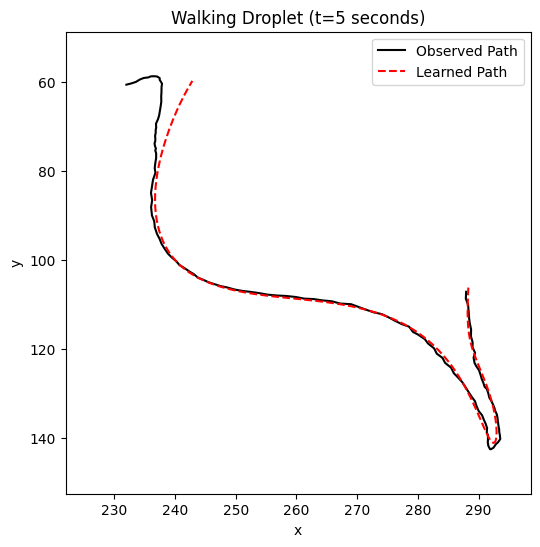

In [14]:
# # Given x and y coordinates
# x = X[:,0]
# y = X[:,1]

# # Additional x and y coordinates
# x2 = sol.y[0,:]
# y2 = sol.y[1,:]

# # Set the desired figure size (width, height) in inches
# figure_size = (6, 6)

# # Set up the figure with a fixed size
# fig, ax = plt.subplots(figsize=figure_size)
# ax.set_title("Walking Droplet (t=5 seconds)")
# ax.set_xlim(min(x)-10, max(x)+5)
# ax.set_ylim(max(y)+10, min(y)-10)

# # Set x-axis and y-axis labels
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# # Create an empty list to store frames
# frames = []

# # Plot the initial points
# line1, = ax.plot([], [], 'k-', label="Observed Path")
# line2, = ax.plot([], [], 'r--', label="Learned Path")

# # Iterate through each coordinate point
# for i in range(len(x)):
#     # Update the plot data for the first set of coordinates
#     line1.set_data(x[:i+1], y[:i+1])
    
#     # Update the plot data for the second set of coordinates
#     line2.set_data(x2[:i+1], y2[:i+1])

#     # Add legend
#     ax.legend(loc='upper right')

#     # Save the plot as an image
#     fig.canvas.draw()
#     frame = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
#     frames.append(frame)


# # Save the frames as a GIF
# frames[0].save('path.gif', format='GIF', append_images=frames[1:], save_all=True, duration=67, loop=0)
